# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка приложений

In [1]:
import os

import pandas as pd
import numpy as np
import time

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython import get_ipython
ipython = get_ipython()


# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

#ml
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import lightgbm
from lightgbm import LGBMRegressor
%pip install catboost
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics


# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns 

import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings 
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

from matplotlib import rcParams, rcParamsDefault

from signal import signal, SIGPIPE, SIG_DFL  
signal(SIGPIPE,SIG_DFL)

Note: you may need to restart the kernel to use updated packages.


<Handlers.SIG_IGN: 1>

In [3]:
#немного опций для удобства

pd.options.display.max_rows = 6
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

large = 16; med = 12; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (12, 8),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

sns.set_palette('deep') 
sns.set_style("whitegrid")

rcParams['figure.figsize'] = 12,12
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
factor = 10
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi*factor

### Загрузка файла

In [4]:
# загружаем файл

pth1='/home/alexandra/data_science/autos.csv'
pth2='/datasets/autos.csv'
pth3='https://code.s3.yandex.net/datasets/autos.csv'

try:
  
    if os.path.exists(pth1):
        df = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2, delimiter='\,')
    # elif os.path.exists(pth3):
    #     df = pd.read_csv(pth3, delimiter='\,')
    else:
        df = pd.read_csv(pth3, delimiter='\,')
  
    print('Загрузка файла прошла успешно')      
    df0=df
except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')

Загрузка файла прошла успешно


In [5]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


### Основная информация о данных

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
#приведем названия колонок к змеиному стилю
df.rename(columns={'DateCrawled': 'Date_Crawled', 'VehicleType':'Vehicle_Type', 'RegistrationYear':'Registration_Year','RegistrationMonth':'Registration_Month', 'FuelType':'Fuel_Type', 'DateCreated':'Date_Created', 'NumberOfPictures':'Number_Of_Pictures', 'PostalCode':'Postal_Code','LastSeen':'Last_Seen'}, inplace=True)
df.columns = df.columns.str.lower()
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [8]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [9]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [10]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [11]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

petrol - бензин, gasoline - тоже бензин. Где то дизель потеряли, но да ладно. Пусть будет так.

### Предобработка данных

In [12]:
# удалила посткод и данные с NAN по столбцу с коробкой передач. 
#Посмотрела, там в основном и по остальным данным нули

df=df.dropna(subset=['gearbox'],axis=0)
df = df.drop('postal_code', axis=1)
df=df.drop(df[(df['power']==0) & (df['registration_month']==0)].index)

df['repaired']=df['repaired'].fillna('unknown')
df['vehicle_type']=df['vehicle_type'].fillna('unknown')
df['model']=df['model'].fillna('unknown')
df['fuel_type']=df['fuel_type'].fillna('unknown')
#df=df.dropna(subset='repaired',axis=0)
df.drop_duplicates()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,2016-03-17 17:40:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,unknown,2016-03-20 00:00:00,0,2016-03-24 12:45:21


In [13]:
#переводим дату в формат даты

df['date_crawled']= pd.to_datetime(df['date_crawled'], format="%Y/%m/%dT%H:%M:%S")
df['date_created']= pd.to_datetime(df['date_created'], format="%Y/%m/%dT%H:%M:%S")
df = df.drop(columns = 'last_seen', axis = 1) 
#подумала и удалила столбцы с датой
df = df.drop('date_crawled', axis=1)
df = df.drop('date_created', axis=1)

In [14]:
# остальные данные заполняем методом ближайших соседей
#df=df.fillna(method='ffill')

In [15]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures
count,326855.000000,326855.000000,326855.000000,326855.000000,326855.000000,326855.0
mean,4615.494886,2003.362268,117.147264,128748.313472,5.995616,0.0
std,4566.322950,28.653383,191.885363,36760.086734,3.585048,0.0
...,...,...,...,...,...,...
50%,2949.000000,2003.000000,107.000000,150000.000000,6.000000,0.0
75%,6700.000000,2008.000000,144.000000,150000.000000,9.000000,0.0
max,20000.000000,9000.000000,20000.000000,150000.000000,12.000000,0.0


In [16]:
# удалим выбивающиеся данные 
df=df.query('registration_year < 2016')
df=df.query('registration_year > 1960')
df=df.query('power < 200')

<AxesSubplot:xlabel='registration_year', ylabel='Count'>

<AxesSubplot:xlabel='power', ylabel='Count'>

<AxesSubplot:xlabel='price', ylabel='Count'>

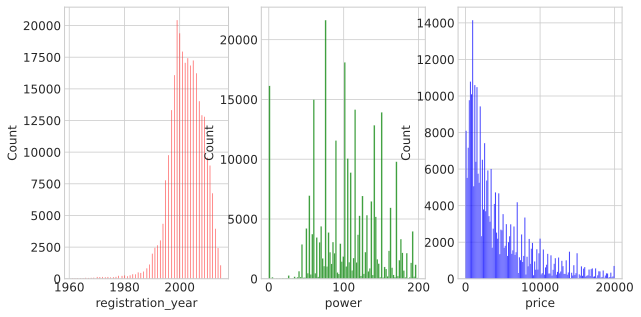

In [17]:
#проверим распределения

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
sns.histplot(x=df['registration_year'], color='r', ax=axes[0])
sns.histplot(x=df['power'], color='g', ax=axes[1])
sns.histplot(x=df['price'], color='b', ax=axes[2])

In [18]:
df.query('power == 0')['power'].count()

16112

In [19]:
df.query('price == 0')['price'].count()
df=df.query('price > 0')

6000

In [20]:
#заполню пропуски по мощности медианным значением по модели

for index in range(len(df)):
    if df['power'].iloc[index] == 0:
        model= df['model'].iloc[index]
        median = df.query('model == @model')['power'].median()
        df['power'].iloc[index] = median 

In [21]:
df.sort_values(by='power')

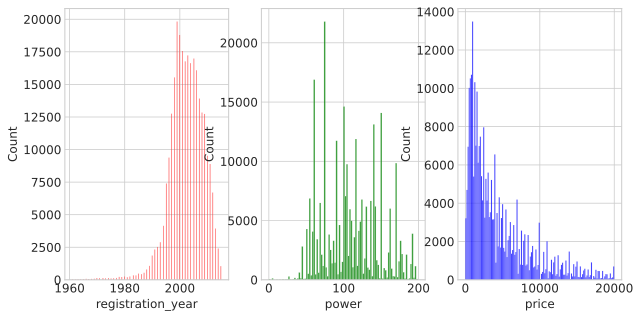

In [39]:
#проверим распределения опять

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
sns.histplot(x=df['registration_year'], color='r', ax=axes[0])
sns.histplot(x=df['power'], color='g', ax=axes[1])
sns.histplot(x=df['price'], color='b', ax=axes[2])

In [22]:
df.info()

### Подготовка данных для машинного обучения

In [23]:
# Делим наши данные 
target = df['price']
features = df.drop('price', axis=1)

features_test, features_train, target_test, target_train = train_test_split(features, target, test_size=0.80, random_state=12345)

features_train.shape
features_test.shape

In [24]:
# кодируем признаки
#!pip install -U scikit-learn

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

cat_columns = df.select_dtypes('object').columns
numeric = ['registration_year', 'power', 'kilometer','registration_month', 'number_of_pictures']


col_transformer = ColumnTransformer(
                    transformers=[
                        ('ss', StandardScaler(), numeric),
                        ('oe', OrdinalEncoder(), cat_columns)
                    ],
                    remainder='drop'
                    )


features_train_oe = col_transformer.fit_transform(features_train)

features_train_oe


In [25]:
#масштабируем признаки

#numeric = ['registration_year', 'power', 'kilometer','registration_month', 'number_of_pictures', 'postal_code']

#scaler = StandardScaler()
#scaler.fit(features_train[numeric])
#features_train[numeric] = scaler.transform(features_train[numeric])
#features_test[numeric] = scaler.transform(features_test[numeric])

In [26]:
# проверяем

#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,2))
#sns.histplot(x=features_train['power'], color='r', ax=axes[0])
#sns.histplot(x=features_train['kilometer'], color='g', ax=axes[1])

## Обучение моделей

### LightGBM

In [27]:
print(lightgbm.__version__)

В связи с тем, что в этом проекте постоянно умирало ядро, я использовала разные другие ресурсы для гридсерча. Но так как на разных платформах разное окружение, то я все таки окончательно формила прект на Яндексе. Но все поисковые команды закоментировала. Смысл я думаю будет понятен.

In [28]:
# строим модель и ищем гиперпараметры.
# сначала грубая оценка более быстрым RandomizedSearchCV
# затем используем GridSearchCV с более мелкой сеткой для уточнения

#ШАГ 1
#model_lgbm = LGBMRegressor()
#params_lgbm = {'max_depth':range(1,15,4), 'n_estimators':range(100, 2000,500), 'min_data_in_leaf':range(10,80,20)}
#grid_model = RandomizedSearchCV(model_lgbm, params_lgbm, cv=3, scoring = 'neg_mean_squared_error', verbose=2, n_jobs=-1, n_iter = 50) #verbose показывает время

#grid_model.fit(features_train, target_train)

#grid_model.best_score_
#grid_model.best_estimator_

#ШАГ 2

cf=df.select_dtypes('object').columns
for c in cf:
    features_train[c] = features_train[c].astype('category')

model_lgbm = LGBMRegressor(boosting_type='gbdt', objective='regression', categorical_feature=[0,2,4,7,8,9])
params_lgbm = {'max_depth':range(13,15), 'n_estimators':range(1000, 2000, 300), 'min_data_in_leaf':range(20,40,10)}
grid_model = GridSearchCV(model_lgbm, params_lgbm,  cv=3, scoring = 'neg_mean_squared_error', verbose=2, n_jobs=-1) #verbose показывает время

grid_model.fit(features_train, target_train)



In [29]:
model_lgbm=grid_model.best_estimator_
mse=grid_model.best_score_

best_index_lgbm = grid_model.best_index_

res_lgbm = (
    pd.DataFrame({
        "mean_score_time": grid_model.cv_results_["mean_score_time"],
        "mean_fit_time": grid_model.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(grid_model.cv_results_["params"]).add_prefix("param_"))
)

fit_time_lgbm = res_lgbm["mean_fit_time"].loc[best_index_lgbm]
score_time_lgbm = res_lgbm['mean_score_time'].loc[best_index_lgbm]
RMSE_lgbm = round((-mse)**0.5,0)

print(f"Fit time: {fit_time_lgbm}, Predict time: {score_time_lgbm}, Best RMSE: {RMSE_lgbm}")

### CatBoost

In [30]:

model_cbc = CatBoostRegressor(cat_features=[0,2,4,7,8,9])
params_cbc = {'iterations':range(10,100,10), 'depth':range(2,21,4)}
grid_model = GridSearchCV(model_cbc, params_cbc, cv=3, scoring = 'neg_mean_squared_error', verbose=True, n_jobs=-1) #verbose показывает время

grid_model.fit(features_train, target_train)


In [31]:
model_cbc=grid_model.best_estimator_
mse=grid_model.best_score_

best_index_cbc = grid_model.best_index_

res_cbc = (
    pd.DataFrame({
        "mean_score_time": grid_model.cv_results_["mean_score_time"],
        "mean_fit_time": grid_model.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(grid_model.cv_results_["params"]).add_prefix("param_"))
)

fit_time_cbc = res_cbc["mean_fit_time"].loc[best_index_cbc]
score_time_cbc = res_cbc['mean_score_time'].loc[best_index_cbc]
RMSE_cbc = round((-mse)**0.5,0)

print(f"Fit time: {fit_time_cbc}, Predict time: {score_time_cbc}, Best RMSE: {RMSE_cbc}")

### Случайный лес

In [32]:
#ШАГ 1
#model_forest = RandomForestRegressor(random_state=12345)
#params_forest = {'max_depth':range(1,15,4), 'n_estimators':range(10, 220,40), 'min_samples_leaf':range(10,80,20)}
#grid_model = RandomizedSearchCV(model_forest, params_forest, cv=3, scoring = 'neg_mean_squared_error', n_iter = 50, verbose=2, n_jobs=-1) #verbose показывает время

#grid_model.fit(features_train, target_train)

#grid_model.best_score_
#grid_model.best_estimator_

#ШАГ 2
model_forest = RandomForestRegressor(random_state=12345)
params_forest = {'max_depth':(15,17), 'n_estimators':(210,240), 'min_samples_leaf':(10,20)}
grid_model = GridSearchCV(model_forest, params_forest, cv=3, scoring = 'neg_mean_squared_error',  verbose=True , n_jobs=-1) #verbose показывает время

grid_model.fit(features_train_oe, target_train)

grid_model.best_score_
grid_model.best_estimator_

In [33]:
model_forest=grid_model.best_estimator_
mse=grid_model.best_score_

best_index_forest = grid_model.best_index_

res_forest = (
    pd.DataFrame({
        "mean_score_time": grid_model.cv_results_["mean_score_time"],
        "mean_fit_time": grid_model.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(grid_model.cv_results_["params"]).add_prefix("param_"))
)

fit_time_forest = res_forest["mean_fit_time"].loc[best_index_forest]
score_time_forest = res_forest['mean_score_time'].loc[best_index_forest]
RMSE_forest = round((-mse)**0.5,0)

print(f"Fit time: {fit_time_forest}, Predict time: {score_time_forest}, Best RMSE: {RMSE_forest}")

## Анализ моделей

Соберем полученные данные в одну таблицу

In [34]:
data = pd.DataFrame({'Мethod': ['LGBMRegressor', 'CatBoostRegressor', "RandomForestRegressor"], 
                   'RMSE': [RMSE_lgbm, RMSE_cbc, RMSE_forest],
                   "Время обучения":[fit_time_lgbm, fit_time_cbc, fit_time_forest],
                   'Время предсказания':[score_time_lgbm, score_time_cbc, score_time_forest]})



In [35]:
data

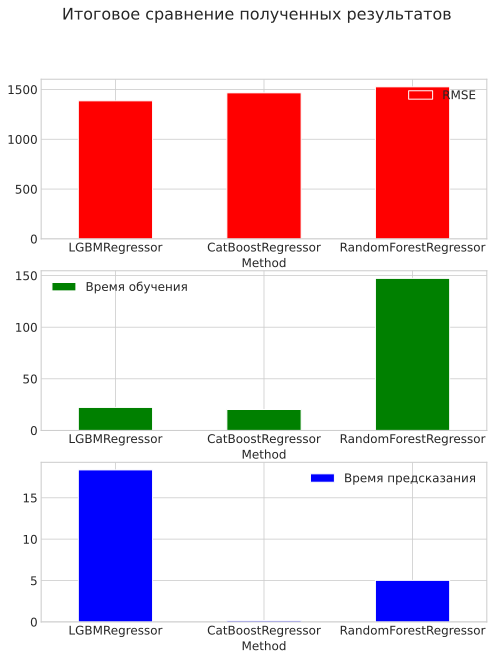

In [36]:
#для наглядности сделаем графики
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,10))
data.plot.bar(x='Мethod', y='RMSE', rot=0, color='r', ax=axes[0])
data.plot.bar(x='Мethod', y='Время обучения', rot=0, color='g', ax=axes[1])
data.plot.bar(x='Мethod', y='Время предсказания', rot=0, color='b', ax=axes[2])
fig.suptitle('Итоговое сравнение полученных результатов', fontsize=16)

In [37]:
# по итогам выбираю CatBoostRegressor как наиболее быстрый

model = model_cbc

start=time.time()

model.fit(features_train, target_train)

end=time.time()

model_cbr_time=round(end-start, 1)

print("Время обучения CatBoostRegressor", model_cbr_time, "секунд")


In [38]:
start=time.time()

preds = model.predict(features_test)

rmse_cbr = round((mean_squared_error(target_test, preds))**0.5,0)

end=time.time()

pred_cbr_time=round(end-start, 1)


print("Время предсказания CatBoostRegressor", model_cbr_time, "секунд")
print ("Метрика RMSE=", rmse_cbr)

**Вывод**: В данной работе мы исследовали продажи авто за большой период с целью найти модель, которая бы обеспечивала хороший результат предсказания (RMSE < 2500), а также быстрое время обучения и предсказания. Всем этим качествам отвечает метод CatBoostRegressor.  На последнем месте по скорости обучения - модель случайного леса.